<a href="https://colab.research.google.com/github/mridul-gupta-ds/Data-Science/blob/master/Trimmed_hotel_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import re
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
df_raw = pd.read_csv("/content/tripadvisor_hotel_reviews.csv")

In [5]:
df = df_raw.copy()

In [6]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [7]:
# Drop NULL comments
df.drop(df[df['Review'].isnull()].index,inplace=True)

In [8]:
!pip install spacy_langdetect
!pip install googletrans

     |████████████████████████████████| 1.0MB 4.3MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993461 sha256=cea1230dee3e878f1394019fdf57ff8e85867ffb0d60c1d203b1d0e048ca748b
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
     |████████████████████████████████| 61kB 2.2MB/s 
     |████████████████████████████████| 972kB 4.2MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 102kB 5.2MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=b90274ca1c5d56581be956f6f6208144f3c5688a0ac558b737060f75511e7747
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-

In [9]:

import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load('en')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
text = 'Nous sommes une équipe'

def language_detector(text):
  doc = nlp(text)
  # document level language detection. Think of it like average language of the document!
  return doc._.language['language']

language_detector(text)

'fr'

In [14]:
from googletrans import Translator
translator=Translator()
def translate_from_french(response,lang):
    print(response)
    if lang == 'fr':
      return translator.translate(response).text
    else:
      return response

translate_from_french(text,'fr')

Nous sommes une équipe


'We are a team'

In [15]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [16]:
df['Responses_demoji'] = df.apply(lambda row: deEmojify(row['Review']), axis=1)

In [17]:
def get_label(rating):
  if rating==5:
    return 1
  elif rating==1 or rating==2:
    return 0
  else:
    return 2

In [18]:
df['label'] = df.apply(lambda row: get_label(row['Rating']),axis=1)

In [19]:
df.head()

,Review,Rating,Responses_demoji,label
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,2
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not 4* experience hotel monaco seat...,2
3,"unique, great stay, wonderful time hotel monac...",5,"unique, great stay, wonderful time hotel monac...",1
4,"great stay great stay, went seahawk game aweso...",5,"great stay great stay, went seahawk game aweso...",1


In [20]:
filterdf = df[df['label']==1]

In [21]:
data = filterdf.Responses_demoji.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['unique, great stay, wonderful time hotel monaco, location excellent short '
 'stroll main downtown shopping area, pet friendly room showed no signs animal '
 'hair smells, monaco suite sleeping area big striped curtains pulled closed '
 'nice touch felt cosy, goldfish named brandi enjoyed, did nt partake free '
 'wine coffee/tea service lobby thought great feature, great staff friendly, '
 'free wireless internet hotel worked suite 2 laptops, decor lovely eclectic '
 'mix pattens color palatte, animal print bathrobes feel like rock stars, nice '
 'did nt look like sterile chain hotel hotel personality excellent stay, ']


In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['unique', 'great', 'stay', 'wonderful', 'time', 'hotel', 'monaco', 'location', 'excellent', 'short', 'stroll', 'main', 'downtown', 'shopping', 'area', 'pet', 'friendly', 'room', 'showed', 'no', 'signs', 'animal', 'hair', 'smells', 'monaco', 'suite', 'sleeping', 'area', 'big', 'striped', 'curtains', 'pulled', 'closed', 'nice', 'touch', 'felt', 'cosy', 'goldfish', 'named', 'brandi', 'enjoyed', 'did', 'nt', 'partake', 'free', 'wine', 'coffee', 'tea', 'service', 'lobby', 'thought', 'great', 'feature', 'great', 'staff', 'friendly', 'free', 'wireless', 'internet', 'hotel', 'worked', 'suite', 'laptops', 'decor', 'lovely', 'eclectic', 'mix', 'pattens', 'color', 'palatte', 'animal', 'print', 'bathrobes', 'feel', 'like', 'rock', 'stars', 'nice', 'did', 'nt', 'look', 'like', 'sterile', 'chain', 'hotel', 'hotel', 'personality', 'excellent', 'stay']]


In [23]:
## Bigram Example

from gensim.models import Phrases
documents_ex = ["this is the team meeting of rattle box", "rattle box","every one in rattle box team is present"]

sentence_stream_ex = [doc.split(" ") for doc in documents_ex]
bigram_ex = Phrases(sentence_stream_ex, min_count=1, threshold=2) ## (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold 
# higher threshold fewer phrases.
sent_ex = ['this', 'is', 'the', 'team', 'meeting', 'of', 'rattle','box','every','one','in','present']
print(bigram_ex[sent_ex])



['this', 'is', 'the', 'team', 'meeting', 'of', 'rattle_box', 'every', 'one', 'in', 'present']


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [24]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)


In [25]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [26]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['room','good','hotel','resort','great','stay','excellent'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['unique', 'wonderful', 'time', 'location', 'short', 'stroll', 'main', 'downtown', 'shopping', 'area', 'friendly', 'show', 'sign', 'animal', 'hair', 'smell', 'area', 'big', 'stripe', 'curtain', 'pull', 'closed', 'nice', 'touch', 'feel', 'cosy', 'goldfish', 'name', 'enjoy', 'partake', 'free', 'wine', 'coffee', 'tea', 'service', 'lobby', 'think', 'feature', 'staff', 'friendly', 'free', 'work', 'laptop', 'lovely', 'eclectic', 'mix', 'patten', 'color', 'animal', 'print', 'bathrobe', 'feel', 'rock', 'star', 'nice', 'look', 'sterile', 'chain', 'personality']]


In [46]:
data_words_bigrams[:1]

[['unique',
  'wonderful',
  'time',
  'monaco',
  'location',
  'short',
  'stroll',
  'main',
  'downtown',
  'shopping',
  'area',
  'pet',
  'friendly',
  'showed',
  'signs',
  'animal',
  'hair',
  'smells',
  'monaco',
  'suite',
  'sleeping',
  'area',
  'big',
  'striped',
  'curtains',
  'pulled',
  'closed',
  'nice',
  'touch',
  'felt',
  'cosy',
  'goldfish',
  'named',
  'brandi',
  'enjoyed',
  'nt',
  'partake',
  'free',
  'wine',
  'coffee',
  'tea',
  'service',
  'lobby',
  'thought',
  'feature',
  'staff',
  'friendly',
  'free',
  'wireless_internet',
  'worked',
  'suite',
  'laptops',
  'decor',
  'lovely',
  'eclectic',
  'mix',
  'pattens',
  'color',
  'palatte',
  'animal',
  'print',
  'bathrobes',
  'feel',
  'like',
  'rock',
  'stars',
  'nice',
  'nt',
  'look',
  'like',
  'sterile',
  'chain',
  'personality']]

In [29]:
data_lemmatized = remove_stopwords(data_lemmatized)

In [30]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)]]


In [31]:
# Readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('animal', 2),
  ('area', 2),
  ('bathrobe', 1),
  ('big', 1),
  ('chain', 1),
  ('closed', 1),
  ('coffee', 1),
  ('color', 1),
  ('cosy', 1),
  ('curtain', 1),
  ('downtown', 1),
  ('eclectic', 1),
  ('enjoy', 1),
  ('feature', 1),
  ('feel', 2),
  ('free', 2),
  ('friendly', 2),
  ('goldfish', 1),
  ('hair', 1),
  ('laptop', 1),
  ('lobby', 1),
  ('location', 1),
  ('look', 1),
  ('lovely', 1),
  ('main', 1),
  ('mix', 1),
  ('name', 1),
  ('nice', 2),
  ('partake', 1),
  ('patten', 1),
  ('personality', 1),
  ('print', 1),
  ('pull', 1),
  ('rock', 1),
  ('service', 1),
  ('shopping', 1),
  ('short', 1),
  ('show', 1),
  ('sign', 1),
  ('smell', 1),
  ('staff', 1),
  ('star', 1),
  ('sterile', 1),
  ('stripe', 1),
  ('stroll', 1),
  ('tea', 1),
  ('think', 1),
  ('time', 1),
  ('touch', 1),
  ('unique', 1),
  ('wine', 1),
  ('wonderful', 1),
  ('work', 1)]]

#LDA

In [32]:
import os       
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     
  !java -version       
install_java()

openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [33]:
 !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
 !unzip mallet-2.0.8.zip

--2020-11-20 08:53:57--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  16.6MB/s    in 0.9s    

2020-11-20 08:53:58 (16.6 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [34]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 

In [35]:
from gensim.models.wrappers import LdaMallet

In [36]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [37]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('walk', 0.06556602760900836),
   ('breakfast', 0.047253053951351466),
   ('minute', 0.028381888834023917),
   ('small', 0.025719744949440734),
   ('city', 0.025569462633375555),
   ('price', 0.023637261426823247),
   ('bus', 0.020674552910109705),
   ('location', 0.02011636145043904),
   ('street', 0.019622576697653448),
   ('easy', 0.018398849266836985)]),
 (1,
  [('staff', 0.044410510911751605),
   ('make', 0.034760662552225825),
   ('feel', 0.02833449979851965),
   ('family', 0.02447456045470934),
   ('travel', 0.02419885050158003),
   ('year', 0.022544590782804182),
   ('home', 0.021399334054420904),
   ('guest', 0.02036011961570274),
   ('friend', 0.018493775317596658),
   ('return', 0.017030391720218023)]),
 (2,
  [('view', 0.05112192600887205),
   ('area', 0.045458460743356736),
   ('restaurant', 0.04046255222016452),
   ('night', 0.030944485119944874),
   ('bar', 0.02594857659675266),
   ('nice', 0.020500452215857702),
   ('place', 0.01996210000430682),
   ('fantastic'

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=10, step=2)

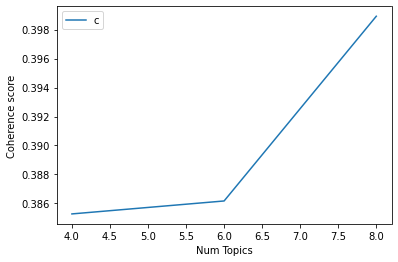

In [40]:
import matplotlib.pyplot as plt

# Show graph
limit=10; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.3853
Num Topics = 6  has Coherence Value of 0.3862
Num Topics = 8  has Coherence Value of 0.3989


In [42]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.055*"staff" + 0.039*"service" + 0.036*"wonderful" + 0.028*"return" + '
  '0.022*"experience" + 0.021*"feel" + 0.020*"love" + 0.019*"make" + '
  '0.015*"year" + 0.015*"family" + 0.015*"beautiful" + 0.013*"visit" + '
  '0.013*"enjoy" + 0.012*"travel" + 0.012*"absolutely" + 0.011*"perfect" + '
  '0.011*"time" + 0.011*"home" + 0.010*"trip" + 0.010*"friendly" + '
  '0.009*"friend" + 0.009*"fabulous" + 0.009*"special" + 0.008*"husband" + '
  '0.007*"ca" + 0.007*"guest" + 0.007*"treat" + 0.007*"property" + '
  '0.006*"star" + 0.005*"warm"'),
 (1,
  '0.050*"location" + 0.048*"staff" + 0.039*"helpful" + 0.038*"walk" + '
  '0.036*"clean" + 0.034*"friendly" + 0.032*"breakfast" + 0.020*"city" + '
  '0.019*"comfortable" + 0.018*"recommend" + 0.014*"close" + 0.014*"quiet" + '
  '0.014*"easy" + 0.014*"price" + 0.013*"lovely" + 0.013*"street" + '
  '0.012*"perfect" + 0.012*"minute" + 0.011*"spacious" + 0.011*"extremely" + '
  '0.010*"station" + 0.010*"short" + 0.010*"modern" + 0.010*"locate"

#PyLDA Vis


In [43]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 4.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=6bd574e583bec399571773d236539325ee22bbd361aed300f393bdf37e7a23fa
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [44]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [45]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model , corpus, dictionary=model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.000698 -0.000255       1        1  21.298388
5      0.000125 -0.000676       2        1  17.233578
2      0.000482  0.000011       3        1  16.242880
4     -0.000381  0.000376       4        1  15.690881
0     -0.000946 -0.000402       5        1  15.134966
1      0.000022  0.000946       6        1  14.399307, topic_info=              Term       Freq      Total Category  logprob  loglift
10977      concede  29.000000  29.000000  Default  30.0000  30.0000
10262      destroy  30.000000  30.000000  Default  29.0000  29.0000
3127     enclosure  29.000000  29.000000  Default  28.0000  28.0000
15998  resplendent  29.000000  29.000000  Default  27.0000  27.0000
4255          deca  31.000000  31.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
8647      snapshot   5.526926  31.463435   Topic6  -9.5809   0.1988
7770        edible   5.581377  32.259962   Topic6  -9.5710   0.1836
5400       rundown   5.500506  31.403808   Topic6  -9.5856   0.1959
3254    oustanding   5.504098  31.744117   Topic6  -9.5850   0.1858
2806      optional   5.496418  31.841867   Topic6  -9.5864   0.1813

[321 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
15068      1  0.194464  ac_worked
15068      2  0.194464  ac_worked
15068      3  0.129643  ac_worked
15068      4  0.162053  ac_worked
15068      5  0.194464  ac_worked
...      ...       ...        ...
13189      2  0.136311   workshop
13189      3  0.136311   workshop
13189      4  0.204466   workshop
13189      5  0.136311   workshop
13189      6  0.136311   workshop

[1854 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 3, 5, 1, 2])